In [1]:
import pandas as pd #Analysis
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis
from scipy.stats import norm #Analysis
from sklearn.preprocessing import StandardScaler #Analysis
from scipy import stats #Analysis
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
from textblob import TextBlob
from nltk import word_tokenize, pos_tag, ne_chunk
import os
import string
color = sns.color_palette()
import spacy
import re
from nltk.tokenize import RegexpTokenizer
%matplotlib inline

from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import os
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob, Word
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
from nltk import FreqDist
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train=pd.read_csv('/content/drive/MyDrive/drugsComTrain_raw.tsv',sep='\t')
test=pd.read_csv('/content/drive/MyDrive/drugsComTest_raw.tsv',sep='\t')

Mounted at /content/drive


In [3]:
print('train shape:',train.shape)
print('test shape:',test.shape)

train shape: (161297, 7)
test shape: (53766, 7)


In [4]:
df=pd.concat([train,test])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [5]:
df.describe()

,Unnamed: 0,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [6]:
df.isnull().sum()

Unnamed: 0        0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.drop(['Unnamed: 0','date'],axis=1,inplace=True)

In [9]:
condition_df=df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_df=pd.DataFrame(condition_df).reset_index()

In [10]:
condition_df

,condition,drugName
0,Not Listed / Othe,253
1,Pain,219
2,Birth Control,181
3,High Blood Pressure,146
4,Acne,127
...,...,...
911,Women (oxybutynin),1
912,Wound Cleansing,1
913,Yellow Fever Prophylaxis,1
914,acial Lipoatrophy,1


Text(0.5, 1.0, 'Top20 : The number of drugs per condition')

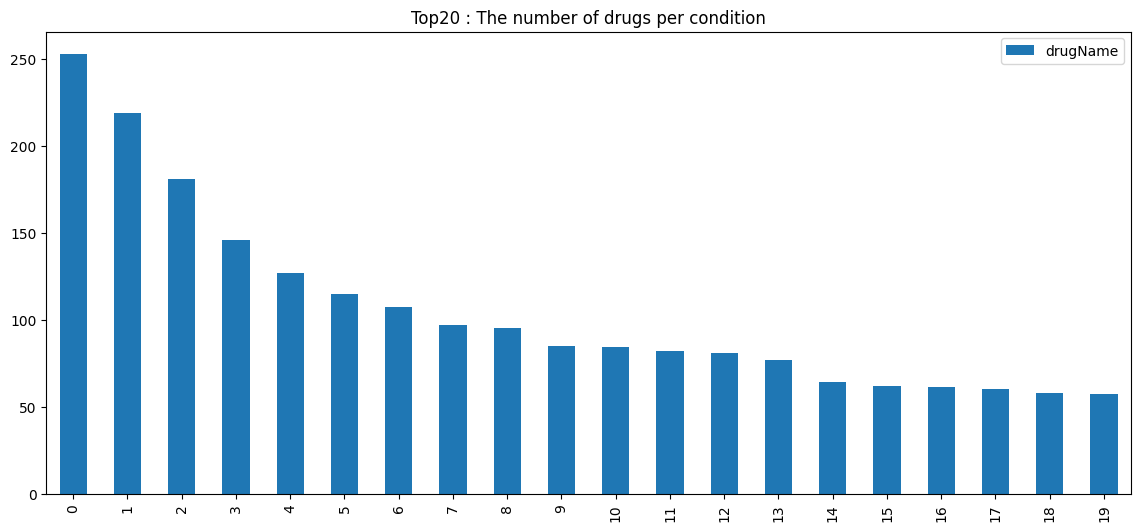

In [11]:
condition_df[:20].plot(kind='bar',figsize=(14,6))
plt.title('Top20 : The number of drugs per condition')

In [12]:
print('data before')
print(df.shape)
df=df[~df.condition.str.contains('</span>',na=False)]
df=df[df['condition']!='Not Listed / Othe']
print('data after')
print(df.shape)

data before
(213869, 5)
data after
(212106, 5)


In [13]:
condition_1=condition_df[condition_df['drugName']==1].reset_index()
all_list=set(df.index)
condition_list=[]
for i,j in enumerate(df['condition']):
    for c in list(condition_1['condition']):
        if j==c:
            condition_list.append(i)
new_idx=all_list-set(condition_list)
df=df.iloc[list(new_idx)].reset_index()
del df['index']

Text(0.5, 1.0, 'Top20 : The number of drug per condition')

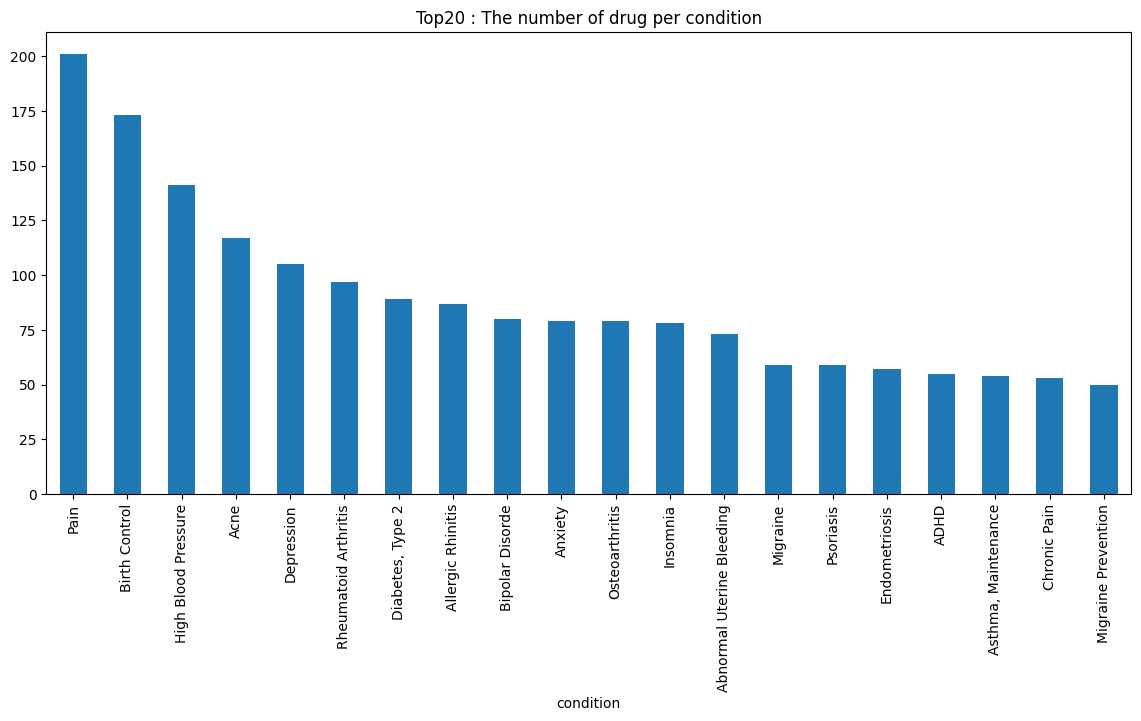

In [14]:
condition_df=df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_df[:20].plot(kind='bar',figsize=(14,6))
plt.title('Top20 : The number of drug per condition')

Text(0.5, 1.0, 'Count of rating values')

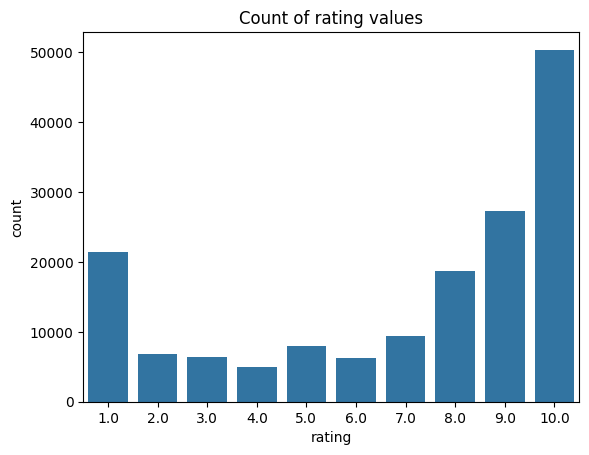

In [15]:
sns.countplot(x='rating',data=df)
plt.title('Count of rating values')

Text(0.5, 1.0, 'Count of useful values')

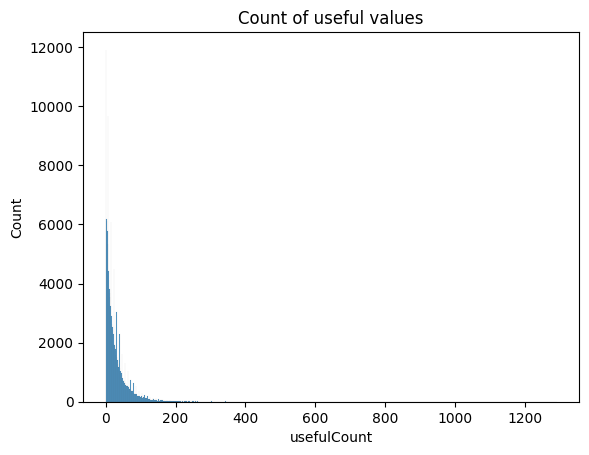

In [16]:
sns.histplot(x='usefulCount',data=df)
plt.title('Count of useful values')

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
stops=set(stopwords.words('english'))
stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

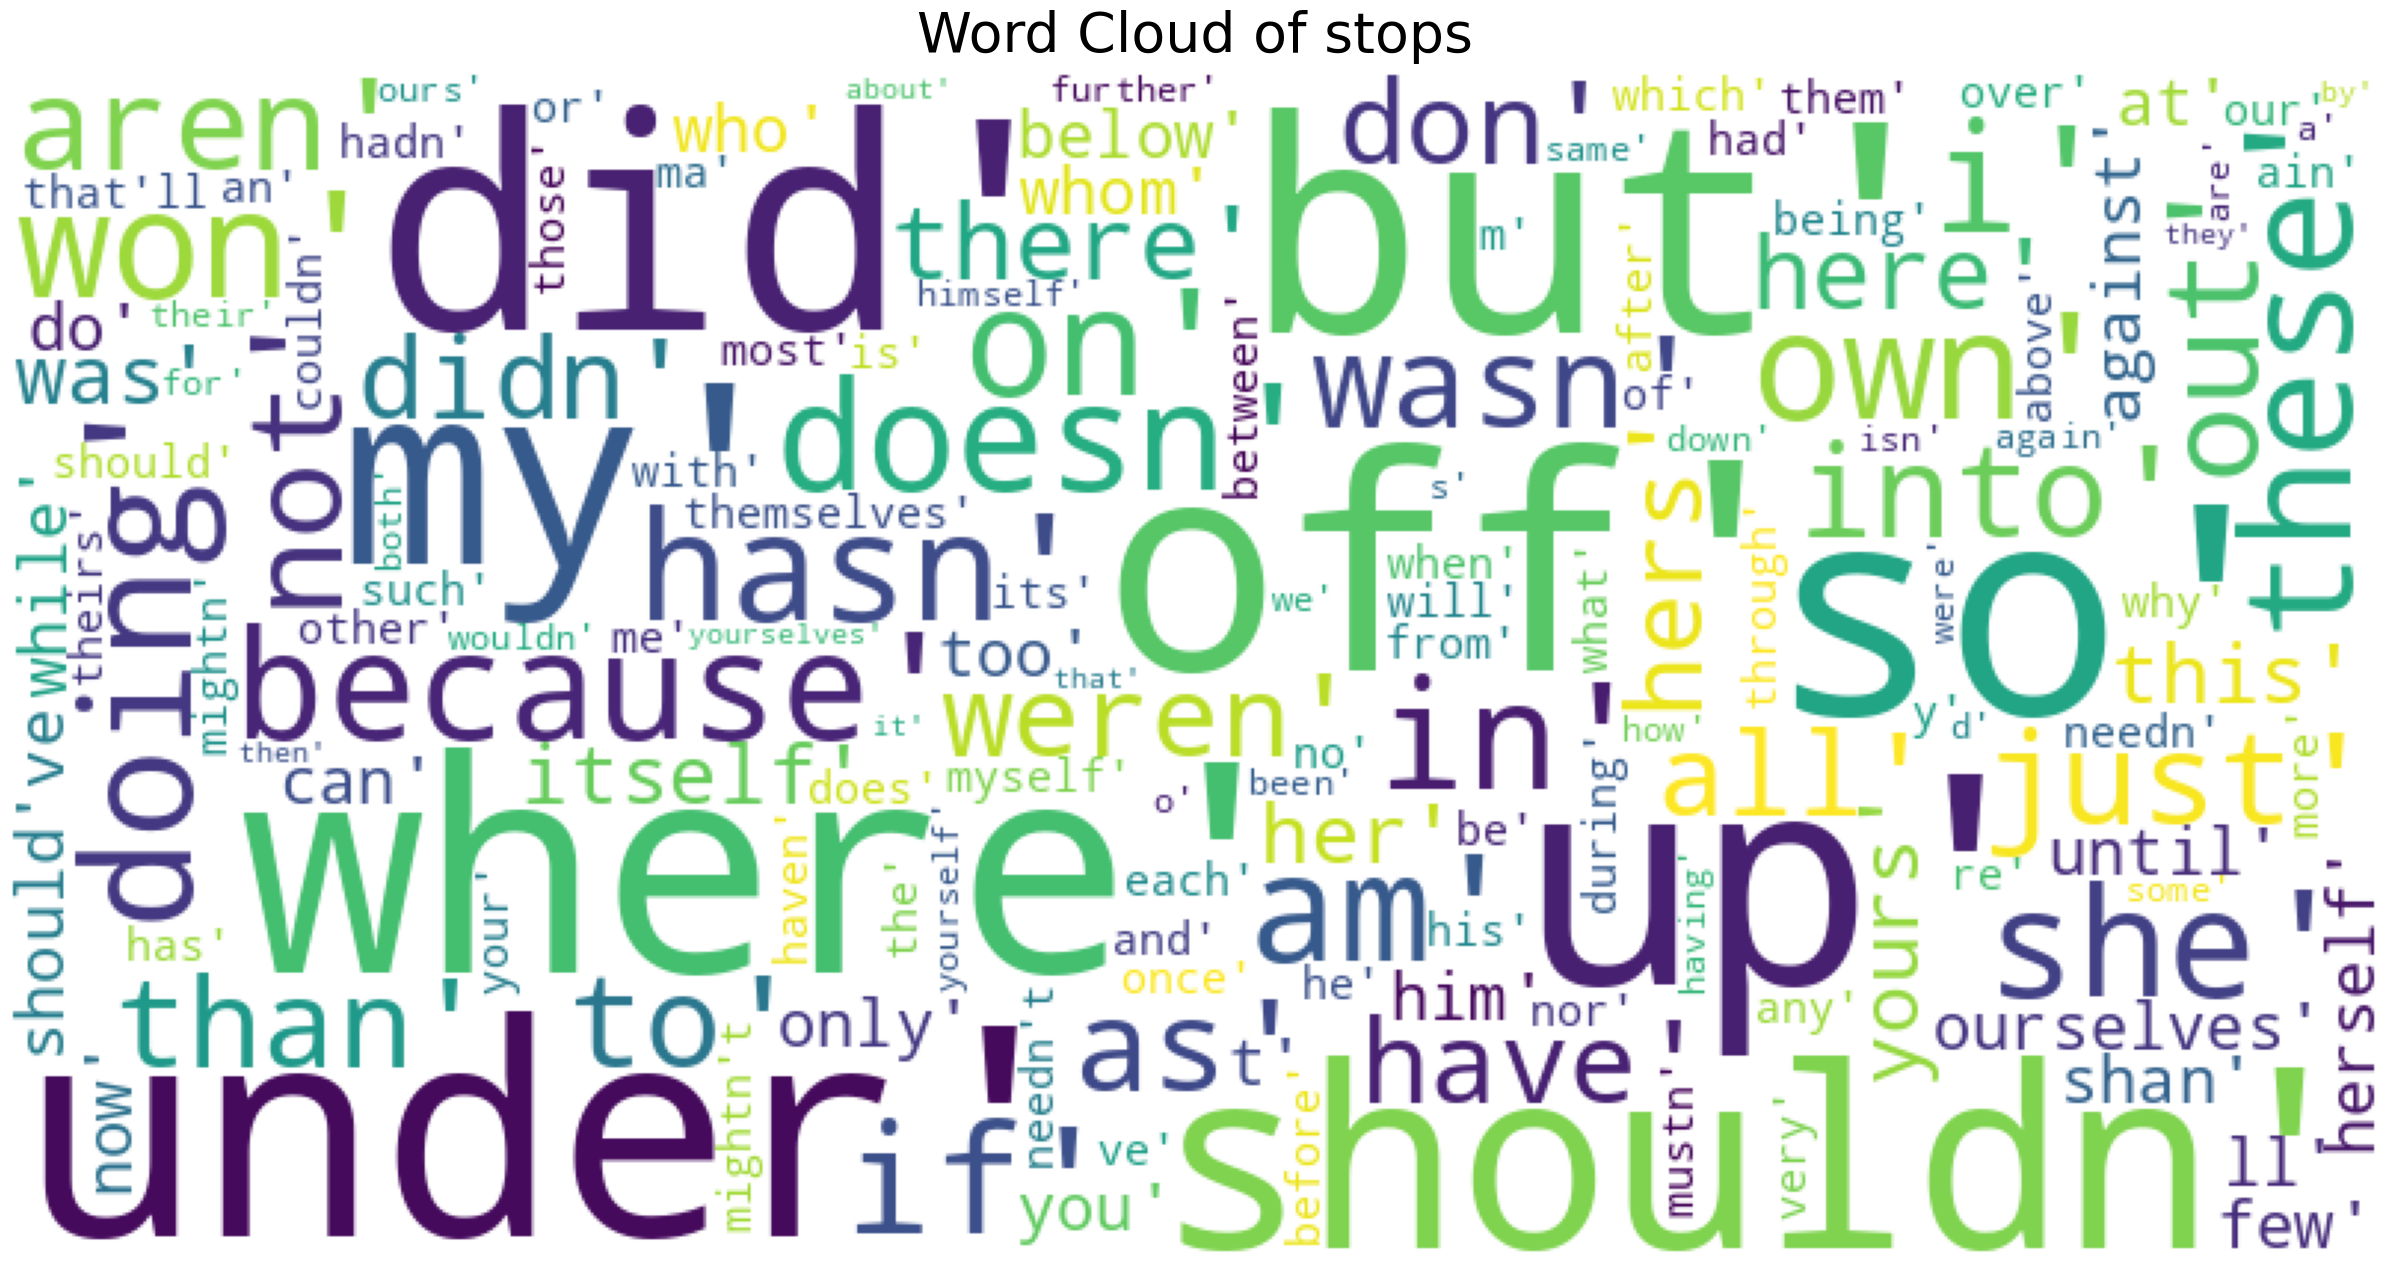

In [19]:
def plot_wordcloud(text,mask=None,max_words=200,max_font_size=100,figure_size=(24,16),title=None,title_size=40,image_color=False):
    stopwords=set(STOPWORDS)
    more_stopwords={'one','br','Po','th','sayi','fo','Unknown'}
    stopwords=stopwords.union(more_stopwords)
    wordcloud=WordCloud(background_color='white',
        stopwords=stopwords,
        max_words=max_words,
        max_font_size=max_font_size,
        random_state=42,
        width=800,
        height=400,
        mask=mask)
    wordcloud.generate(str(text))
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors=ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors),interpolation='bilinear')
        plt.title(title, fontdict={'size': title_size,'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

plot_wordcloud(stops, title="Word Cloud of stops")

In [20]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

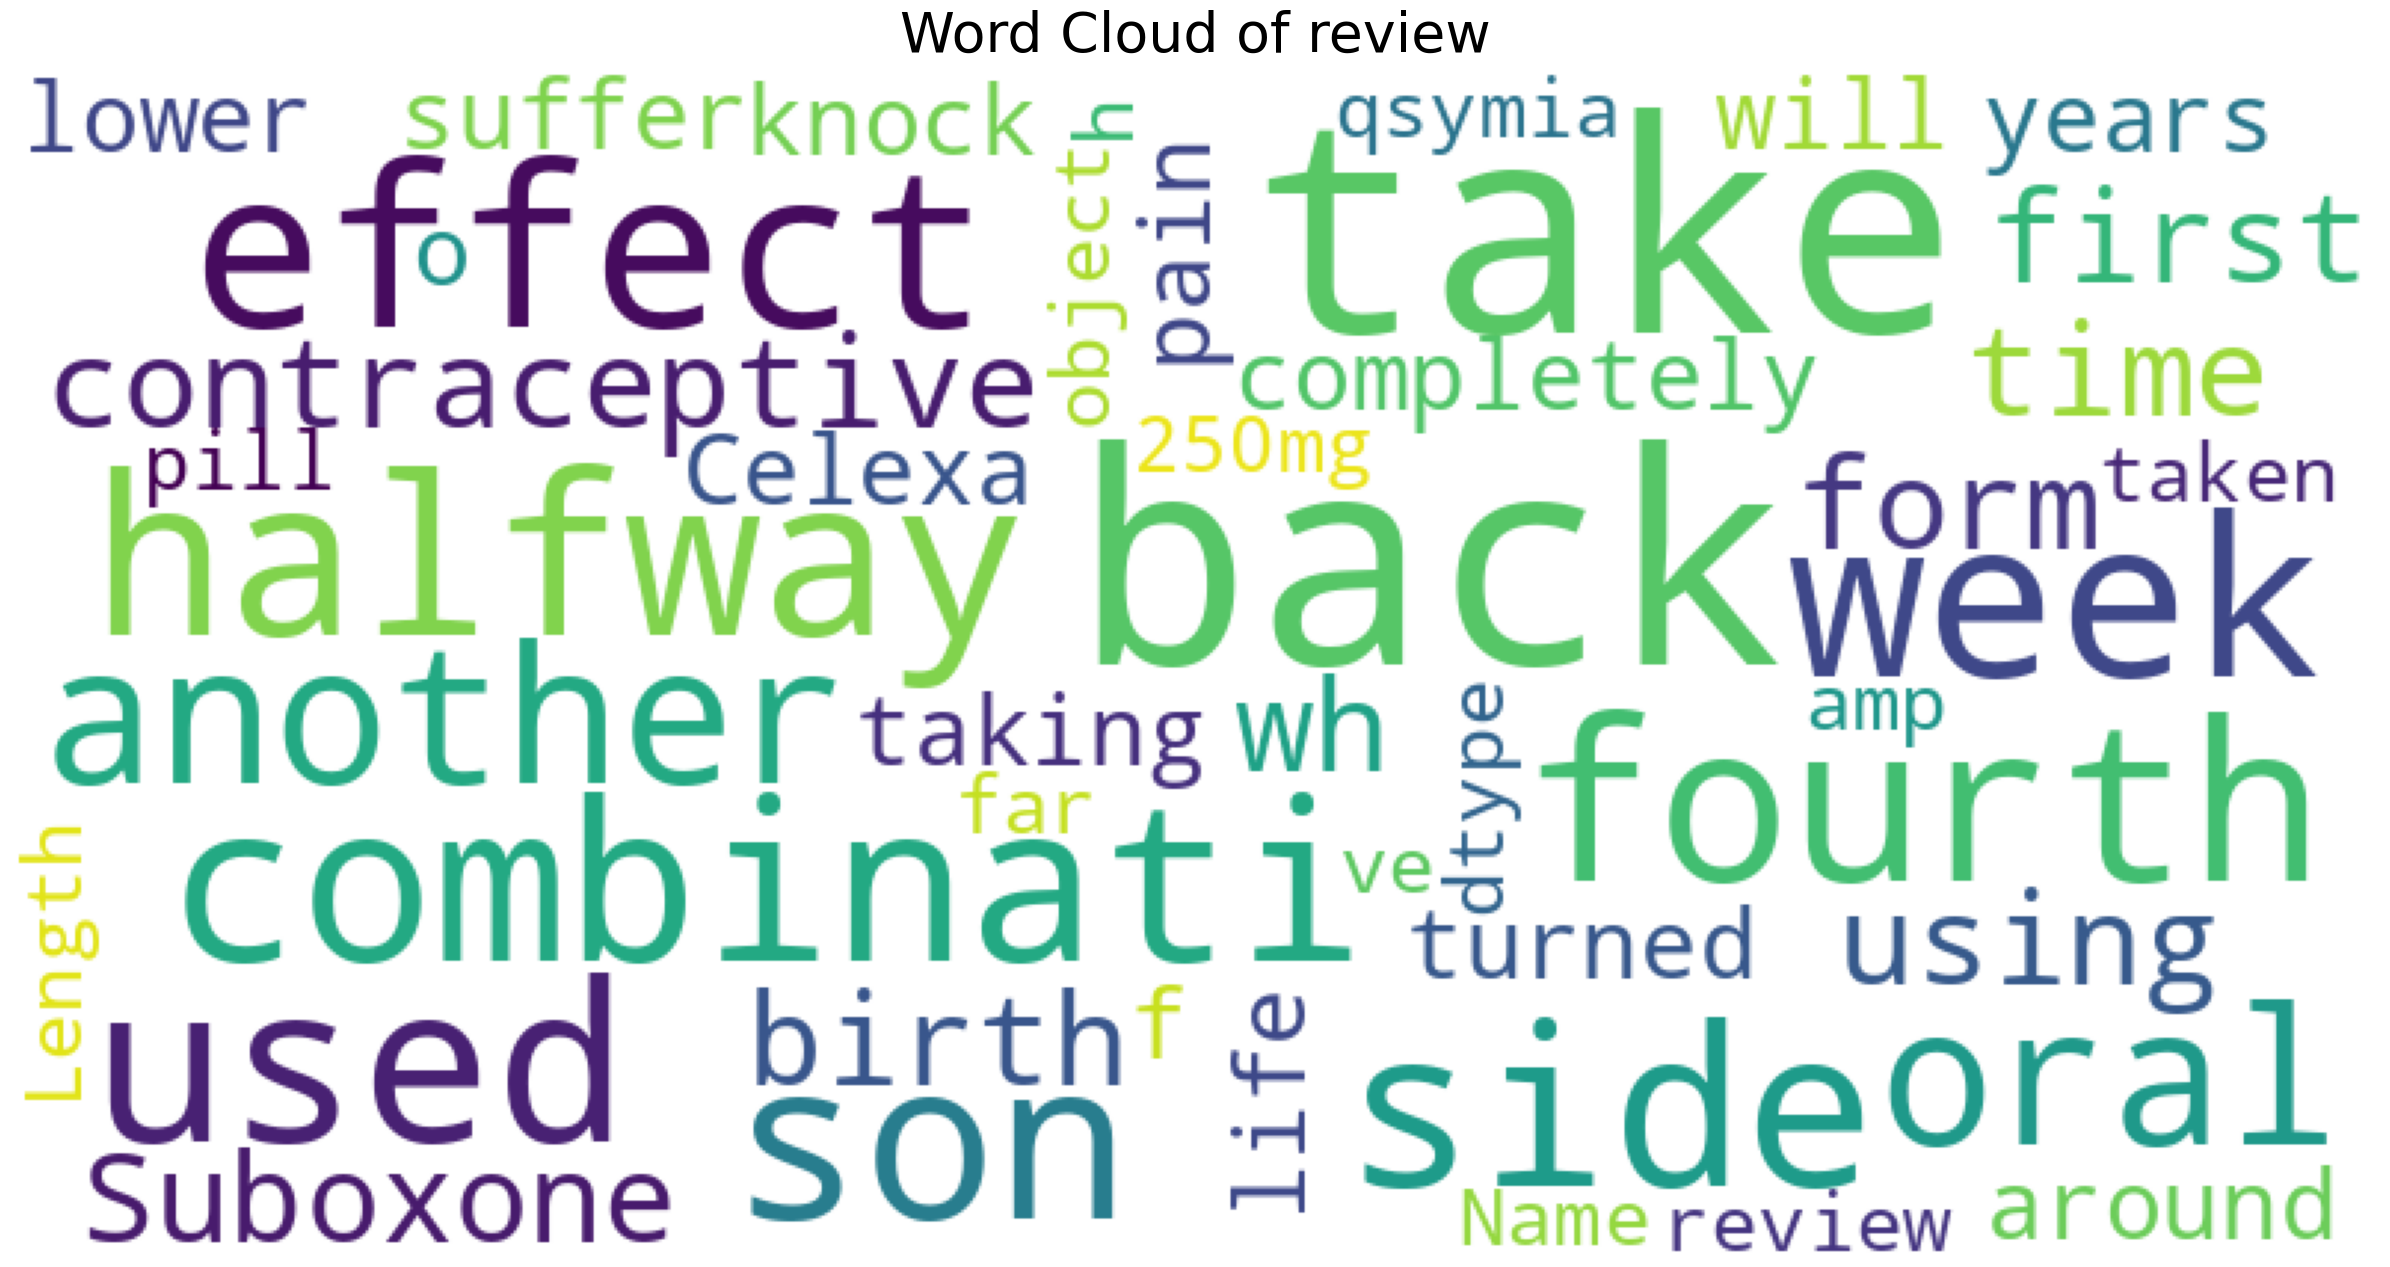

In [21]:
plot_wordcloud(df['review'],title='Word Cloud of review')

In [22]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.decomposition import TruncatedSVD

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [23]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return ' '.join(stemming_words)

In [24]:
%time df['review_clean'] = df['review'].apply(review_to_words)

CPU times: user 1min 42s, sys: 292 ms, total: 1min 42s
Wall time: 1min 43s


In [25]:
df

,drugName,condition,review,rating,usefulCount,review_clean
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,27,no side effect take combin bystol mg fish oil
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,192,son halfway fourth week intuniv becam concern ...
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,17,use take anoth oral contracept pill cycl happi...
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,10,first time use form birth control glad went pa...
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,37,suboxon complet turn life around feel healthie...
...,...,...,...,...,...,...
159323,Diazepam,Muscle Spasm,"""I suffer from lower back pain. I had a back f...",9.0,105,suffer lower back pain back fusion novemb mont...
159324,Celexa,Depression,"""I have been taking Celexa for 4 years. All o...",8.0,74,take celexa year sudden stop work spent day fe...
159325,Thorazine,Light Sedation,"""This will knock you out.""",10.0,32,knock
159326,Qsymia,Weight Loss,"""I have been on qsymia since 7/20/16 &amp; I h...",10.0,69,qsymia sinc lost lbs littl no side effect


In [26]:
df['sentiment']=df['rating'].apply(lambda x: 1 if x>5 else 0)

In [27]:
from transformers import AutoTokenizer

In [28]:
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [29]:
df

,drugName,condition,review,rating,usefulCount,review_clean,sentiment
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,27,no side effect take combin bystol mg fish oil,1
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,192,son halfway fourth week intuniv becam concern ...,1
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,17,use take anoth oral contracept pill cycl happi...,0
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,10,first time use form birth control glad went pa...,1
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,37,suboxon complet turn life around feel healthie...,1
...,...,...,...,...,...,...,...
159323,Diazepam,Muscle Spasm,"""I suffer from lower back pain. I had a back f...",9.0,105,suffer lower back pain back fusion novemb mont...,1
159324,Celexa,Depression,"""I have been taking Celexa for 4 years. All o...",8.0,74,take celexa year sudden stop work spent day fe...,1
159325,Thorazine,Light Sedation,"""This will knock you out.""",10.0,32,knock,1
159326,Qsymia,Weight Loss,"""I have been on qsymia since 7/20/16 &amp; I h...",10.0,69,qsymia sinc lost lbs littl no side effect,1


In [42]:
x_train,x_test,y_train,y_test=train_test_split(list(df['review_clean']),df['sentiment'],test_size=0.2,random_state=42)

In [43]:
print(len(x_train))
print(len(x_test))
print(y_train.shape)
print(y_test.shape)

127462
31866
(127462,)
(31866,)


In [ ]:
x_train_enc=tokenizer(x_train,padding=True)
x_test_enc=tokenizer(x_test,padding=True)

In [32]:
import tensorflow as tf
train_dataset=tf.data.Dataset.from_tensor_slices((
    dict(x_train_enc),
    y_train
))
test_dataset=tf.data.Dataset.from_tensor_slices((
    dict(x_test),
    y_test
))

In [33]:
from transformers import TFDistilBertForSequenceClassification
model=TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [1]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(optimizer='Adam', loss=model.compute_loss, metrics=['accuracy'])

# start training model
model.fit(train_dataset,
          epochs=2,
          validation_data=test_dataset)

NameError: name 'model' is not defined